# German Credit Risk

### Models Implemented:
- Logistic Regression (Vanilla, L1, L2)
- KNN
- Decision Tree (with and without GridSearchCV)

## Logistic Regression on German Credit Risk

### Our goal is to:
- Implement Logistic Regression with vanilla, l1 and l2 penalty.
- Impact on the coefficient of hypothesis because of lasso and ridge regression.
- Assess the different metrics on these different implementation of Logistic Regression.
- Evaluate False Positive Rate (FPR) on these models using Confusion Matrix.
- Visualize Receiver Operating Characteristics (ROC) curve and Precision-Recall curve to see the trend.

### Imports

In [1]:
import numpy as np
import pandas as pd

from scipy import stats 
import math

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from colorsetup import colors, palette

### Read the data

In [2]:
gcr_data = pd.read_csv("gcr_processed.csv")

In [3]:
gcr_data.head()

,Age,Sex,Job,Credit amount,Duration,Risk,Housing_free,Housing_own,Housing_rent,Saving accounts_little,...,Checking account_rich,Purpose_business,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others,Credit_amount/duration
0,4.219508,1,2,7.064759,1.945910,1,0,1,0,0,...,0,0,0,0,0,0,1,0,0,3.630568
1,3.135494,0,2,8.691483,3.891820,0,0,1,0,1,...,0,0,0,0,0,0,1,0,0,2.233269
2,3.912023,1,1,7.648263,2.564949,1,0,1,0,1,...,0,0,0,0,1,0,0,0,0,2.981838
3,3.828641,1,2,8.972464,3.761200,1,1,0,0,1,...,0,0,0,0,0,1,0,0,0,2.385532
4,3.988984,1,2,8.491055,3.218876,0,1,0,0,1,...,0,0,1,0,0,0,0,0,0,2.637894


### Separating feature and target

In [4]:
X = gcr_data.drop(['Risk','Credit amount'], axis=1)
y = gcr_data['Risk']

In [5]:
X.shape

(1000, 23)

### Feature Selection

#### 1. Univariate Selection

In [6]:
#apply SelectKBest class to extract top 5 best features
bestfeatures = SelectKBest(score_func=chi2, k=6)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

In [7]:
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns, dfscores], axis=1)
featureScores.columns = ['Specs', 'Score']  #naming the dataframe columns
print(featureScores.nlargest(10, 'Score'))  #print best features

                         Specs      Score
11     Checking account_little  48.450469
12   Checking account_moderate  10.453001
7       Saving accounts_little  10.291479
19            Purpose_radio/TV   8.231293
6                 Housing_rent   7.068103
10        Saving accounts_rich   7.000000
4                 Housing_free   5.932981
5                  Housing_own   5.198758
9   Saving accounts_quite rich   4.717309
3                     Duration   4.699713


In [8]:
#X = gcr_data[featureScores.nlargest(23, 'Score')['Specs'].values]

#### 2. Feature Importance

In [9]:
from sklearn.ensemble import ExtraTreesClassifier

In [10]:
model = ExtraTreesClassifier()
model.fit(X,y)
#print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers

ExtraTreesClassifier()

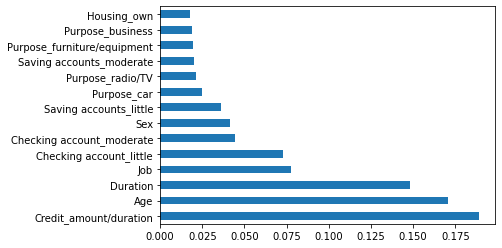

In [11]:
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.sort_values(ascending=True).nlargest(14).plot(kind='barh')
plt.show()

In [12]:
X = gcr_data[feat_importances.nlargest(15).index]

In [13]:
#X.head()

#### 3. Correlation Matrix with Heatmap

### StratifiedShuffleSplit

In [14]:
from sklearn.model_selection import StratifiedShuffleSplit

strat_shuf_split = StratifiedShuffleSplit(n_splits=1, 
                                          test_size=0.3, 
                                          random_state=42)

train_idx, test_idx = next(strat_shuf_split.split(X, gcr_data.Risk))

# Create the dataframes
X_train = X.loc[train_idx, X.columns]
y_train = gcr_data.loc[train_idx, 'Risk']

X_test  = X.loc[test_idx, X.columns]
y_test  = gcr_data.loc[test_idx, 'Risk']

### Logistic Regression: Vanilla, L1 and L2

In [15]:
from sklearn.linear_model import LogisticRegression

# Standard logistic regression
lr = LogisticRegression(solver='liblinear').fit(X_train, y_train)

In [16]:
from sklearn.linear_model import LogisticRegressionCV

# L1 regularized logistic regression
lr_l1 = LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver='liblinear').fit(X_train, y_train)

In [17]:
# L2 regularized logistic regression
lr_l2 = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='liblinear').fit(X_train, y_train)

### Metrics

In [18]:
coefficients = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

for lab,mod in zip(coeff_labels, coeff_models):
    coeffs = mod.coef_
    coeff_label = pd.MultiIndex(levels=[[lab], [0,1]], 
                                 codes=[[0], [0]])
    coefficients.append(pd.DataFrame(coeffs.T, columns=coeff_label))

coefficients = pd.concat(coefficients, axis=1)

#coefficients.sample(5)

y_pred = list()
y_prob = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

for lab,mod in zip(coeff_labels, coeff_models):
    y_pred.append(pd.Series(mod.predict(X_test), name=lab))
    y_prob.append(pd.Series(mod.predict_proba(X_test).max(axis=1), name=lab))
    
y_pred = pd.concat(y_pred, axis=1)
y_prob = pd.concat(y_prob, axis=1)

#y_pred.head()

from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize

metrics = list()
cm = dict()

for lab in coeff_labels:

    # Preciision, recall, f-score from the multi-class support function
    precision, recall, fscore, _ = score(y_test, y_pred[lab], average='weighted')
    
    # The usual way to calculate accuracy
    accuracy = accuracy_score(y_test, y_pred[lab])
    
    # ROC-AUC scores can be calculated by binarizing the data
    auc = roc_auc_score(label_binarize(y_test, classes=[0,1]),
              label_binarize(y_pred[lab], classes=[0,1]), 
              average='weighted')
    
    # Last, the confusion matrix
    cm[lab] = confusion_matrix(y_test, y_pred[lab])
    #tn, fp, fn, tp = confusion_matrix(y_test, y_pred[lab])
    
    metrics.append(pd.Series({'precision':precision, 'recall':recall, 
                              'fscore':fscore, 'accuracy':accuracy,
                              'auc':auc}, 
                             name=lab))

metrics = pd.concat(metrics, axis=1)

metrics

,lr,l1,l2
precision,0.701343,0.726737,0.729861
recall,0.723333,0.743333,0.746667
fscore,0.702356,0.726975,0.719631
accuracy,0.723333,0.743333,0.746667
auc,0.618254,0.648413,0.631746


### Confusion Matrix and FPR

,LR,Lasso,Ridge
0,0.436364,0.40678,0.354167


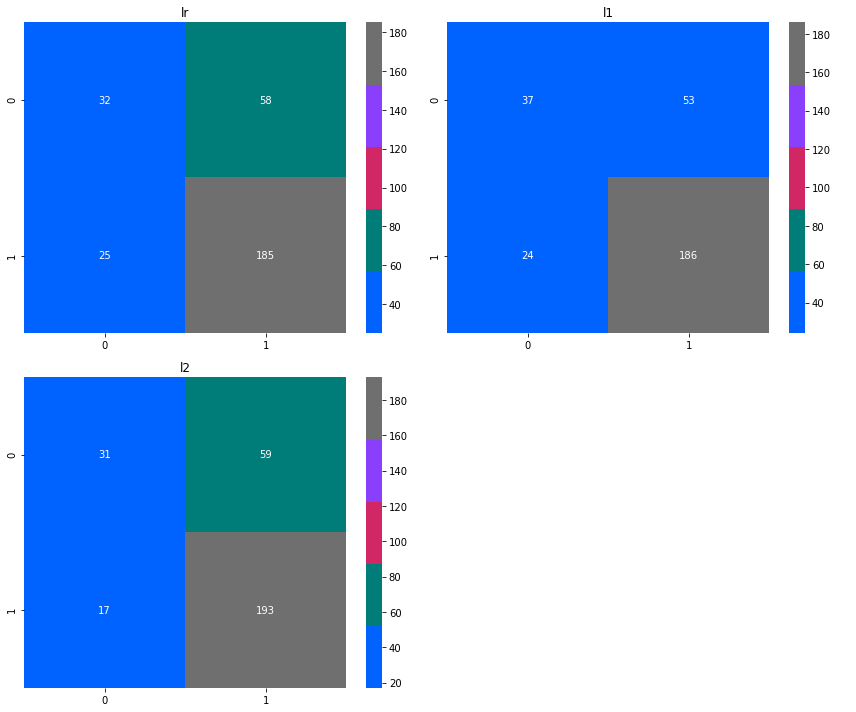

In [19]:
fig, axList = plt.subplots(nrows=2, ncols=2)
axList = axList.flatten()
fig.set_size_inches(12, 10)

axList[-1].axis('off')

for ax,lab in zip(axList[:-1], coeff_labels):
    sns.heatmap(cm[lab], ax=ax, annot=True, fmt='d', cmap=colors);
    ax.set(title=lab);
    
plt.tight_layout()

fpr_lr = 24/(31+24)
fpr_l1 = 24/(24+35)
fpr_l2 = 17/(17+31)

fpr_dict = [{'LR': fpr_lr, 'Lasso': fpr_l1, 'Ridge': fpr_l2}]
fpr_df = pd.DataFrame(data=fpr_dict)
fpr_df

### ROC curve and Precision-Recall curve

### Conclusion
- We have selected 15 features according to feature selection, we are getting maximum accuracy of 74.7% and minimum FPR of 35.4%
- Lasso zeroes out many coefficients of the hypothesis, whereas ridge does not.
- Ridge implementation outperforms than vanilla and lasso regression, which is clearly reflected in the Metrics section.
- Moreover, the ridge regression gives the minimum FPR among the models.
- Polynomial Features i.e. (Credit_amount_duration) helped us to improve the accuracy and f1 score on this dataset for all implementations.

## KNN on German Credit Risk

### Imports

In [20]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score

### Feature Selection

In [21]:
#X = gcr_data[featureScores.nlargest(14, 'Score')['Specs'].values]

In [22]:
X = gcr_data[feat_importances.nlargest(14).index]

In [23]:
#X.info()

### Stratified Shuffle Split

In [24]:
from sklearn.model_selection import StratifiedShuffleSplit

strat_shuf_split = StratifiedShuffleSplit(n_splits=1, 
                                          test_size=0.3, 
                                          random_state=42)

train_idx, test_idx = next(strat_shuf_split.split(X, gcr_data.Risk))

# Create the dataframes
X_train = X.loc[train_idx, X.columns]
y_train = gcr_data.loc[train_idx, 'Risk']

X_test  = X.loc[test_idx, X.columns]
y_test  = gcr_data.loc[test_idx, 'Risk']

### KNN

In [25]:
# Estimate KNN model and report outcomes
knn_3 = KNeighborsClassifier(n_neighbors=3)
knn_3 = knn_3.fit(X_train, y_train)
y_pred_3 = knn_3.predict(X_test)

In [26]:
knn_5 = KNeighborsClassifier(n_neighbors=5, weights='distance')
knn_5 = knn_5.fit(X_train, y_train)
y_pred_5 = knn_5.predict(X_test)

### Iterating the model with different K values

In [27]:
max_k = 100
f1_scores = list()
error_rates = list() # 1-accuracy

for k in range(1, max_k):
    
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
    knn = knn.fit(X_train, y_train)
    
    y_pred = knn.predict(X_test)
    f1 = f1_score(y_pred, y_test)
    f1_scores.append((k, round(f1_score(y_test, y_pred), 4)))
    error = 1-round(accuracy_score(y_test, y_pred), 4)
    error_rates.append((k, error))
    
f1_results = pd.DataFrame(f1_scores, columns=['K', 'F1 Score'])
error_results = pd.DataFrame(error_rates, columns=['K', 'Error Rate'])

#f1_results.head()

### Plotting F1 results

<Figure size 1800x1200 with 0 Axes>

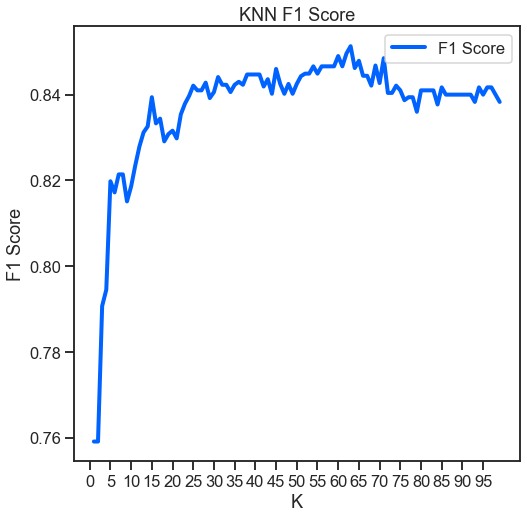

In [28]:
# Plot F1 results
sns.set_context('talk')
sns.set_style('ticks')

plt.figure(dpi=300)
ax = f1_results.set_index('K').plot(color=colors[0], figsize=(8, 8), linewidth=4)
ax.set(xlabel='K', ylabel='F1 Score')
ax.set_xticks(range(0, max_k, 5));
plt.title('KNN F1 Score')
plt.savefig('knn_f1.png')

### Plotting Error rate results

<Figure size 1800x1200 with 0 Axes>

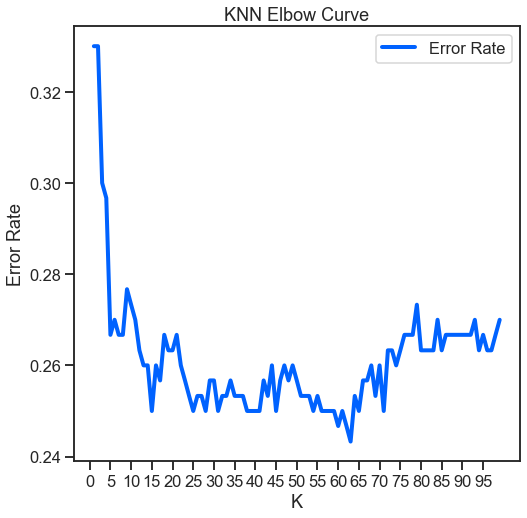

In [29]:
# Plot Accuracy (Error Rate) results
sns.set_context('talk')
sns.set_style('ticks')

plt.figure(dpi=300)
ax = error_results.set_index('K').plot(color=colors[0], figsize=(8, 8), linewidth=4)
ax.set(xlabel='K', ylabel='Error Rate')
ax.set_xticks(range(0, max_k, 5))
plt.title('KNN Elbow Curve')
plt.savefig('knn_elbow.png')

### Metrics

In [30]:
knn_best = KNeighborsClassifier(n_neighbors=63, weights='distance')
knn_best = knn_best.fit(X_train, y_train)
y_pred_best = knn_best.predict(X_test)

In [31]:
coeff_labels = ['KNN_3', 'KNN_5', 'KNN_best']
coeff_models = [knn_3, knn_5, knn_best]

y_pred = list()
y_prob = list()

for lab,mod in zip(coeff_labels, coeff_models):
    y_pred.append(pd.Series(mod.predict(X_test), name=lab))
    y_prob.append(pd.Series(mod.predict_proba(X_test).max(axis=1), name=lab))
    
y_pred = pd.concat(y_pred, axis=1)
y_prob = pd.concat(y_prob, axis=1)

metrics = list()
cm = dict()

for lab in coeff_labels:

    # Preciision, recall, f-score from the multi-class support function
    precision, recall, fscore, _ = score(y_test, y_pred[lab], average='weighted')
    
    # The usual way to calculate accuracy
    accuracy = accuracy_score(y_test, y_pred[lab])
    
    # ROC-AUC scores can be calculated by binarizing the data
    auc = roc_auc_score(label_binarize(y_test, classes=[0,1]),
              label_binarize(y_pred[lab], classes=[0,1]), 
              average='weighted')
    
    # Last, the confusion matrix
    cm[lab] = confusion_matrix(y_test, y_pred[lab])
    
    metrics.append(pd.Series({'precision':precision, 'recall':recall, 
                              'fscore':fscore, 'accuracy':accuracy,
                              'auc':auc}, 
                             name=lab))

metrics = pd.concat(metrics, axis=1)

metrics

,KNN_3,KNN_5,KNN_best
precision,0.688619,0.717172,0.804851
recall,0.703333,0.733333,0.756667
fscore,0.693633,0.720028,0.695009
accuracy,0.703333,0.733333,0.756667
auc,0.619841,0.644444,0.597619


### Confusion Matrix and FPR

,KNN_3,KNN_5,KNN_best
0,0.493151,0.424242,0.052632


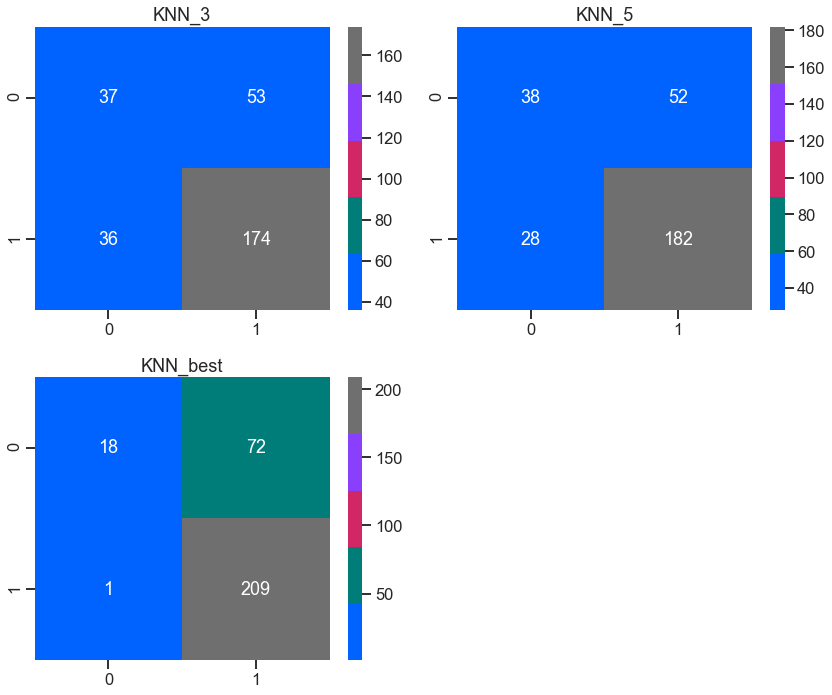

In [32]:
fig, axList = plt.subplots(nrows=2, ncols=2)
axList = axList.flatten()
fig.set_size_inches(12, 10)

axList[-1].axis('off')

for ax,lab in zip(axList[:-1], coeff_labels):
    sns.heatmap(cm[lab], ax=ax, annot=True, fmt='d', cmap=colors);
    ax.set(title=lab);
    
plt.tight_layout()

fpr_knn_3 = 36/(36+37)
fpr_knn_5 = 28/(38+28)
fpr_knn_best = 1/(1+18)

fpr_dict = [{'KNN_3': fpr_knn_3, 'KNN_5': fpr_knn_5, 'KNN_best': fpr_knn_best}]
fpr_df = pd.DataFrame(data=fpr_dict)
fpr_df

### Conclusion
- KNN performs comparably better than Logistic Regression when number of features are set to 14.
- KNN with number of neighbours equal to 63 gives a best result for this data set. The accuracy comes to 75.7%, F1-score comes to 84.5%, FPR reduces to 5.2%, however AUC decreases to 59.8%.
- Also, the FPR is quite low.
- Moreover, other metrics such as precision, recall, f1-score are comparable to that of Logistic Regression.

## Decision Tree Classifier on German Credit Risk

### Imports

In [33]:
from sklearn.tree import DecisionTreeClassifier

### Feature Selection

In [34]:
X = gcr_data[feat_importances.nlargest(13).index]
#X = gcr_data[featureScores.nlargest(16, 'Score')['Specs'].values]

### StratifiedShuffleSplit

In [35]:
from sklearn.model_selection import StratifiedShuffleSplit

strat_shuf_split = StratifiedShuffleSplit(n_splits=1, 
                                          test_size=0.3, 
                                          random_state=42)

train_idx, test_idx = next(strat_shuf_split.split(X, gcr_data.Risk))

# Create the dataframes
X_train = X.loc[train_idx, X.columns]
y_train = gcr_data.loc[train_idx, 'Risk']

X_test  = X.loc[test_idx, X.columns]
y_test  = gcr_data.loc[test_idx, 'Risk']

### Decision Tree

In [36]:
dt = DecisionTreeClassifier(random_state=42)
dt = dt.fit(X_train, y_train)

dt.tree_.node_count, dt.tree_.max_depth

(349, 19)

### Metrics

In [37]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def measure_error(y_true, y_pred, label):
    return pd.Series({'accuracy':accuracy_score(y_true, y_pred),
                      'precision': precision_score(y_true, y_pred),
                      'recall': recall_score(y_true, y_pred),
                      'f1': f1_score(y_true, y_pred),
                      'auc': roc_auc_score(label_binarize(y_true, classes=[0,1]),
                      label_binarize(y_pred, classes=[0,1]), 
                      average='weighted')},
                      name=label)

# The error on the training and test data sets
y_train_pred = dt.predict(X_train)
y_test_pred = dt.predict(X_test)



train_test_full_error = pd.concat([measure_error(y_train, y_train_pred, 'train'),
                              measure_error(y_test, y_test_pred, 'test')],
                              axis=1)

train_test_full_error

,train,test
accuracy,1.0,0.693333
precision,1.0,0.786408
recall,1.0,0.771429
f1,1.0,0.778846
auc,1.0,0.641270


### Decision Tree with GridSearchCV

In [38]:
from sklearn.model_selection import GridSearchCV

# hyperparameters
param_grid = {'max_depth':range(1, dt.tree_.max_depth+1, 2), 
              'max_features': range(1, len(dt.feature_importances_)+1)}

GR = GridSearchCV(DecisionTreeClassifier(random_state=42),
                  param_grid=param_grid,
                  scoring='accuracy',
                  n_jobs=-1)

GR = GR.fit(X_train, y_train)

GR.best_estimator_.tree_.node_count, GR.best_estimator_.tree_.max_depth

(55, 5)

### Metrics

In [39]:
y_train_pred_gr = GR.predict(X_train)
y_test_pred_gr = GR.predict(X_test)

train_test_gr_error = pd.concat([measure_error(y_train, y_train_pred_gr, 'train'),
                                 measure_error(y_test, y_test_pred_gr, 'test')],
                                axis=1)

train_test_gr_error

,train,test
accuracy,0.788571,0.723333
precision,0.804270,0.747082
recall,0.922449,0.914286
f1,0.859316,0.822270
auc,0.699320,0.596032


### Confusion Matrix and FPR

0.51

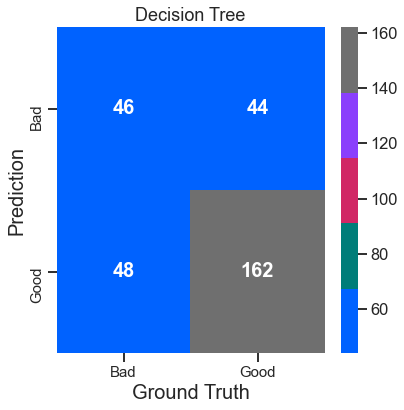

In [40]:
# Plot confusion matrix
_, ax = plt.subplots(figsize=(6,6))
ax = sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt='d', cmap=colors, annot_kws={"size": 20, "weight": "bold"})  
labels = ['Good', 'Bad']
ax.set_xticklabels(labels[::-1], fontsize=15);
ax.set_yticklabels(labels[::-1], fontsize=15);
ax.set_ylabel('Prediction', fontsize=20);
ax.set_xlabel('Ground Truth', fontsize=20)
ax.set(title='Decision Tree')

fpr_dt = 49/(49+47)
np.round(fpr_dt,2)

0.34

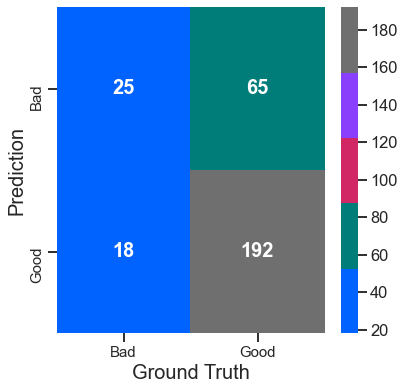

In [41]:
# Plot confusion matrix
_, ax = plt.subplots(figsize=(6,6))
ax = sns.heatmap(confusion_matrix(y_test, y_test_pred_gr), annot=True, fmt='d', cmap=colors, annot_kws={"size": 20, "weight": "bold"})  
labels = ['Good', 'Bad']
ax.set_xticklabels(labels[::-1], fontsize=15);
ax.set_yticklabels(labels[::-1], fontsize=15);
ax.set_ylabel('Prediction', fontsize=20);
ax.set_xlabel('Ground Truth', fontsize=20)

fpr_dt_gcv = 13/(13+25)
np.round(fpr_dt_gcv,2)

### Visualize the decision trees

### Conclusion
- Decision Tree without GridSearchCV gives an accuracy of 69.33% and with GridSearchCV 74%.
- GridSearchCV reduces the node count and depth of trees to a significant amount which make it compute faster.
- The FPR obtained by GridSearchCV is 34.2% which is substantially better than vanilla Decision Tree.
- However, other metrics such as precision, recall and f1-score are comparatively better than Logistic Regression and KNN.

## Bagging ensemble methods on German Credit Risk data set

### Imports

In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

### Feature Selection

In [43]:
X = gcr_data[feat_importances.nlargest(12).index]
#X = gcr_data[featureScores.nlargest(16, 'Score')['Specs'].values]

In [44]:
#X.head()

### StratifiedShuffleSplit

In [45]:
from sklearn.model_selection import StratifiedShuffleSplit

strat_shuf_split = StratifiedShuffleSplit(n_splits=1, 
                                          test_size=0.3, 
                                          random_state=42)

train_idx, test_idx = next(strat_shuf_split.split(X, gcr_data.Risk))

# Create the dataframes
X_train = X.loc[train_idx, X.columns]
y_train = gcr_data.loc[train_idx, 'Risk']

X_test  = X.loc[test_idx, X.columns]
y_test  = gcr_data.loc[test_idx, 'Risk']

### Random Forest Classifier

In [46]:
# Suppress warnings about too few trees from the early models
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [47]:
# Initialize the random forest estimator
# Note that the number of trees is not setup here

# oob_score > Whether to use out-of-bag samples to estimate the generalization accuracy.
# warm_start > When set to True, reuse the solution of the previous call to fit and add more estimators to the ensemble, otherwise, just fit a whole new forest.
# n_jobs > The number of jobs to run in parallel. fit, predict, decision_path and apply are all parallelized over the trees. None means 1 unless in a joblib.parallel_backend context. -1 means using all processors. 

RF = RandomForestClassifier(oob_score=True,
                            random_state=42, 
                            warm_start=True,
                            n_jobs=-1)

oob_list = list()

# Iterate through all of the possibilities for 
# number of trees
for n_trees in [15, 20, 30, 40, 50, 100, 150, 200, 300, 400]:
    
    # Use this to set the number of trees
    RF.set_params(n_estimators=n_trees)

    # Fit the model
    RF.fit(X_train, y_train)

    # Get the oob error
    oob_error = 1 - RF.oob_score_
    
    # Store it
    oob_list.append(pd.Series({'n_trees': n_trees, 'oob': oob_error}))

rf_oob_df = pd.concat(oob_list, axis=1).T.set_index('n_trees')

#rf_oob_df

### ExtraTreesClassifier

In [48]:
# Initialize the random forest estimator
# Note that the number of trees is not setup here

# bootstrap > Whether bootstrap samples are used when building trees. If False, the whole dataset is used to build each tree.

EF = ExtraTreesClassifier(oob_score=True, 
                          random_state=42, 
                          warm_start=True,
                          bootstrap=True,
                          n_jobs=-1)

oob_list = list()

# Iterate through all of the possibilities for 
# number of trees
for n_trees in [15, 20, 30, 40, 50, 100, 150, 200, 300, 400]:
    
    # Use this to set the number of trees
    EF.set_params(n_estimators=n_trees)
    EF.fit(X_train, y_train)

    # oob error
    oob_error = 1 - EF.oob_score_
    oob_list.append(pd.Series({'n_trees': n_trees, 'oob': oob_error}))

et_oob_df = pd.concat(oob_list, axis=1).T.set_index('n_trees')

#et_oob_df

## Comparison between the models

In [49]:
oob_df = pd.concat([rf_oob_df.rename(columns={'oob':'RandomForest'}),
                    et_oob_df.rename(columns={'oob':'ExtraTrees'})], axis=1)

#oob_df

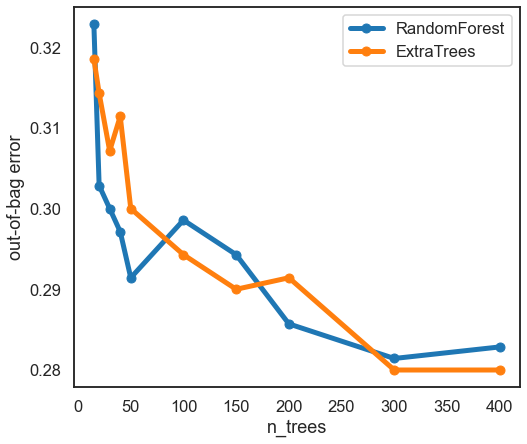

In [50]:
sns.set_context('talk')
sns.set_style('white')

ax = oob_df.plot(marker='o', figsize=(8, 7), linewidth=5)
ax.set(ylabel='out-of-bag error');

#### Metrics

In [51]:
RF_opt = RF.set_params(n_estimators=300)
EF_opt = EF.set_params(n_estimators=300)

In [52]:
y_pred = list()
y_prob = list()

labels = ['rf', 'ef']
models = [RF_opt, EF_opt]

for lab,mod in zip(labels, models):
    y_pred.append(pd.Series(mod.predict(X_test), name=lab))
    y_prob.append(pd.Series(mod.predict_proba(X_test).max(axis=1), name=lab))
    
y_pred = pd.concat(y_pred, axis=1)
y_prob = pd.concat(y_prob, axis=1)

# y_pred.head()
# y_prob.head()

metrics = list()
cm = dict()

for lab in labels:

    # Precision, recall, f-score from the multi-class support function
    precision, recall, fscore, _ = score(y_test, y_pred[lab], average='weighted')
    
    # The usual way to calculate accuracy
    accuracy = accuracy_score(y_test, y_pred[lab])
    
    # ROC-AUC scores can be calculated by binarizing the data
    auc = roc_auc_score(label_binarize(y_test, classes=[0,1]),
              label_binarize(y_pred[lab], classes=[0,1]), 
              average='weighted')
    
    # Last, the confusion matrix
    cm[lab] = confusion_matrix(y_test, y_pred[lab])
    
    metrics.append(pd.Series({'precision':precision, 'recall':recall, 
                              'fscore':fscore, 'accuracy':accuracy,
                              'auc':auc}, 
                             name=lab))

metrics = pd.concat(metrics, axis=1)

metrics

,rf,ef
precision,0.721487,0.739195
recall,0.740000,0.753333
fscore,0.719462,0.739701
accuracy,0.740000,0.753333
auc,0.636508,0.665079


#### Confusion Matrix

,FPR_RF,FPR_ET
0,0.392857,0.375


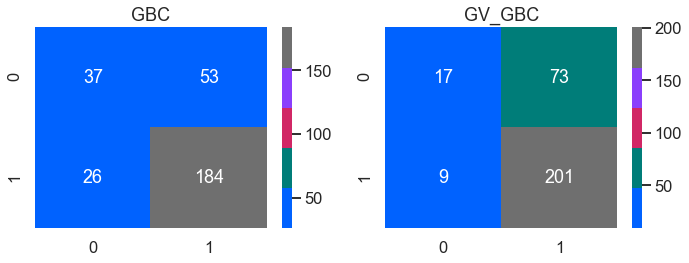

In [71]:
sns.set_context('talk')

fig, axList = plt.subplots(nrows=1, ncols=2)
axList = axList.flatten()
fig.set_size_inches(10, 4)


for ax,lab in zip(axList, labels):
    sns.heatmap(cm[lab], ax=ax, annot=True, fmt='d', cmap=colors);
    ax.set(title=lab);
    
plt.tight_layout()

fpr_rf = 22/(22+34)
fpr_et = 24/(24+40)

fpr_dict = [{'FPR_RF': fpr_rf, 'FPR_ET': fpr_et}]
fpr_df = pd.DataFrame(data=fpr_dict)
fpr_df

### Conclusion
- Both RandomForestClassifier and ExtraTreeClassifier give better results at 12 important features.
- ExtraTreesClassifier gives better accuracy and minimum FPR than RandomForestClassifier.

## Boosting and Stacking on German Credit Risk data set

### Imports

In [55]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

### Feature Selection

In [178]:
X = gcr_data[feat_importances.nlargest(13).index]
#X = gcr_data[featureScores.nlargest(16, 'Score')['Specs'].values]

### StratifiedShuffleSplit

In [179]:
from sklearn.model_selection import StratifiedShuffleSplit

strat_shuf_split = StratifiedShuffleSplit(n_splits=1, 
                                          test_size=0.3, 
                                          random_state=42)

train_idx, test_idx = next(strat_shuf_split.split(X, gcr_data.Risk))

# Create the dataframes
X_train = X.loc[train_idx, X.columns]
y_train = gcr_data.loc[train_idx, 'Risk']

X_test  = X.loc[test_idx, X.columns]
y_test  = gcr_data.loc[test_idx, 'Risk']

### GradientBoostingTree

In [180]:
error_list = list()

# Iterate through various possibilities for number of trees
tree_list = [15, 25, 50, 100, 200, 400]
for n_trees in tree_list:
    
    # Initialize the gradient boost classifier
    GBC = GradientBoostingClassifier(n_estimators=n_trees, random_state=42)

    # Fit the model
    print(f'Fitting model with {n_trees} trees')
    GBC.fit(X_train.values, y_train.values)
    y_pred_gb = GBC.predict(X_test)

    # Get the error
    error = 1.0 - accuracy_score(y_test, y_pred_gb)
    
    # Store it
    error_list.append(pd.Series({'n_trees': n_trees, 'error': error}))

error_df = pd.concat(error_list, axis=1).T.set_index('n_trees')

#error_df

Fitting model with 15 trees
Fitting model with 25 trees
Fitting model with 50 trees
Fitting model with 100 trees
Fitting model with 200 trees
Fitting model with 400 trees


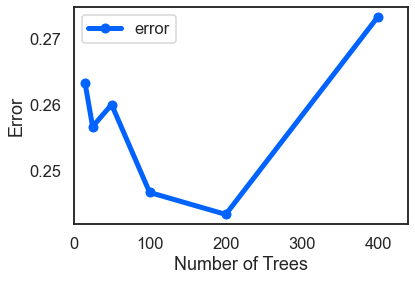

In [181]:
sns.set_context('talk')
sns.set_style('white')
sns.set_palette(palette)

# Create the plot
ax = error_df.plot(marker='o', figsize=(6, 4), linewidth=5)

# Set parameters
ax.set(xlabel='Number of Trees', ylabel='Error')
ax.set_xlim(0, max(error_df.index)*1.1);

### GradientBoostingClassifier with GridSearchCV

In [182]:
from sklearn.model_selection import GridSearchCV

# The parameters to be fit
param_grid = {'n_estimators': tree_list,
              'learning_rate': [0.1, 0.01, 0.001, 0.0001],
              'subsample': [1.0, 0.5],
              'max_features': [1, 2, 3, 4]}

# The grid search object
GV_GBC = GridSearchCV(GradientBoostingClassifier(random_state=42), 
                      param_grid=param_grid, 
                      scoring='accuracy',
                      n_jobs=-1)

# Do the grid search
GV_GBC = GV_GBC.fit(X_train, y_train)

# The best model
GV_GBC.best_estimator_

GradientBoostingClassifier(max_features=1, n_estimators=200, random_state=42)

### AdaBoostClassifier with GridSearchCV

In [183]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ABC = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1))

param_grid = {'n_estimators': [100, 150, 200],
              'learning_rate': [0.01, 0.001]}

GV_ABC = GridSearchCV(ABC,
                      param_grid=param_grid, 
                      scoring='accuracy',
                      n_jobs=-1)

GV_ABC = GV_ABC.fit(X_train, y_train)

# The best model
GV_ABC.best_estimator_

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.01, n_estimators=100)

### VotingClassifier

In [184]:
from sklearn.linear_model import LogisticRegression

# L2 regularized logistic regression
LR_L2 = LogisticRegression(penalty='l2', max_iter=500, solver='saga').fit(X_train, y_train)

from sklearn.ensemble import VotingClassifier

# The combined model--logistic regression and gradient boosted trees
estimators = [('LR_L2', LR_L2), ('GBC', GV_GBC)]

VC = VotingClassifier(estimators, voting='soft')
VC = VC.fit(X_train, y_train)

### Metrics

In [185]:
y_pred = list()
y_prob = list()

labels = ['GBC', 'GV_GBC', 'GV_ABC', 'VC']
models = [GBC, GV_GBC, GV_ABC, VC]

for lab,mod in zip(labels, models):
    y_pred.append(pd.Series(mod.predict(X_test), name=lab))
    y_prob.append(pd.Series(mod.predict_proba(X_test).max(axis=1), name=lab))
    
y_pred = pd.concat(y_pred, axis=1)
y_prob = pd.concat(y_prob, axis=1)

from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize

metrics = list()
cm = dict()

for lab in labels:

    # Precision, recall, f-score from the multi-class support function
    precision, recall, fscore, _ = score(y_test, y_pred[lab], average='weighted')
    
    # The usual way to calculate accuracy
    accuracy = accuracy_score(y_test, y_pred[lab])
    
    # ROC-AUC scores can be calculated by binarizing the data
    auc = roc_auc_score(label_binarize(y_test, classes=[0,1]),
              label_binarize(y_pred[lab], classes=[0,1]), 
              average='weighted')
    
    # Last, the confusion matrix
    cm[lab] = confusion_matrix(y_test, y_pred[lab])
    
    metrics.append(pd.Series({'precision':precision, 'recall':recall, 
                              'fscore':fscore, 'accuracy':accuracy,
                              'auc':auc}, 
                             name=lab))

metrics = pd.concat(metrics, axis=1)

metrics

,GBC,GV_GBC,GV_ABC,VC
precision,0.706667,0.725774,0.735932,0.729498
recall,0.726667,0.743333,0.710000,0.746667
fscore,0.708444,0.723873,0.604669,0.723279
accuracy,0.726667,0.743333,0.710000,0.746667
auc,0.626984,0.642063,0.519841,0.638095


### Confusion Matrix

,FPR_GBC,FPR_GV_GBC,FPR_GV_ABC,FPR_VC
0,0.433333,0.385965,0.2,0.365385


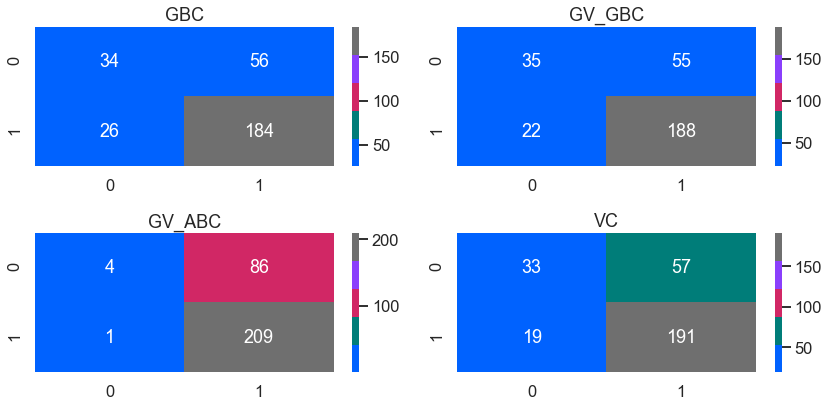

In [187]:
sns.set_context('talk')

fig, axList = plt.subplots(nrows=2, ncols=2)
axList = axList.flatten()
fig.set_size_inches(12, 6)


for ax,lab in zip(axList, labels):
    sns.heatmap(cm[lab], ax=ax, annot=True, fmt='d', cmap=colors);
    ax.set(title=lab);
    
plt.tight_layout()

fpr_gbc = 26/(26+34)
fpr_gv_gbc = 22/(22+35)
fpr_gv_abc = 1/(1+4)
fpr_vc = 19/(19+33)

fpr_dict = [{'FPR_GBC': fpr_gbc, 'FPR_GV_GBC': fpr_gv_gbc, 'FPR_GV_ABC': fpr_gv_abc, 'FPR_VC': fpr_vc}]
fpr_df = pd.DataFrame(data=fpr_dict)
fpr_df